In [ ]:
from types import SimpleNamespace
import os
import json
import torch
import re
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm

## DDPM

In [ ]:
@torch.no_grad()
def generate_batch(prompts, unet, vae, tokenizer, text_encoder, device, steps=50, guidance_scale=7.5):
    unet.eval()
    noise_scheduler = DDPMScheduler()
    scheduler = DPMSolverMultistepScheduler.from_config(noise_scheduler.config)
    scheduler.set_timesteps(steps)

    batch_size = len(prompts)
    cond_ids = tokenizer(prompts, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.to(device)
    uncond_ids = tokenizer([""] * batch_size, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.to(device)

    cond_emb = text_encoder(cond_ids)[0]
    uncond_emb = text_encoder(uncond_ids)[0]
    encoder_input = torch.cat([uncond_emb, cond_emb], dim=0)  # (2B, 77, D)

    latents = torch.randn((batch_size, 4, 32, 32)).to(device)

    for t in scheduler.timesteps:
        latent_input = latents.repeat(2, 1, 1, 1)
        noise_pred = unet(latent_input, t.to(device), encoder_hidden_states=encoder_input).sample
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents = latents / 0.18215
    images = vae.decode(latents, return_dict=False)[0]
    images = (images.clamp(-1, 1) + 1) / 2

    pil_images = [transforms.ToPILImage()(img.cpu()) for img in images]
    return pil_images

def test_inference(ckpt_path, test_json_path, save_folder, device="cuda", steps=50, guidance_scale=7.5, batch_size=4):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").eval().to(device)
    text_encoder.requires_grad_(False)
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
    vae.requires_grad_(False)

    print(f"🔍 Loading checkpoint: {ckpt_path}")
    # 1. 初始化 unet（使用原始 config）
    unet = UNet2DConditionModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    layers_per_block=3,
    block_out_channels=(192, 384, 768),
    down_block_types=(
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D"
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D"
    ),
    cross_attention_dim=512,
    attention_head_dim=8
    ).to(device)

    # 2. 載入訓練好的權重（推薦用 EMA）
    ckpt = torch.load(ckpt_path, map_location=device)
    if "ema" in ckpt:
        print("✅ Using EMA weights")
        unet.load_state_dict(ckpt["ema"])
    else:
        print("⚠️ Using raw UNet weights")
        unet.load_state_dict(ckpt["unet"])

    os.makedirs(save_folder, exist_ok=True)
    with open(test_json_path, "r") as f:
        test_data = list(json.load(f).items())

    print(f"🚀 Start batch inference: {len(test_data)} samples | Batch size={batch_size}")
    for i in tqdm(range(0, len(test_data), batch_size), desc="Batch generating"):
        batch_items = test_data[i:i+batch_size]
        prompts = [item[1]["text_prompt"] for item in batch_items]
        filenames = [item[1]["image_name"] for item in batch_items]

        images = generate_batch(prompts, unet, vae, tokenizer, text_encoder, device,
                                steps=steps, guidance_scale=guidance_scale)
        for img, fname in zip(images, filenames):
            img.save(os.path.join(save_folder, fname))



In [ ]:
class ImageSizeError(ValueError):
    pass

class FIDDataset(Dataset):
    def __init__(self, image_paths: str, image_size: int = None):
        self.image_paths = image_paths
        self.image_size = image_size

        self.transform = transforms.Compose([
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * 3, [0.5] * 3)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.image_size is not None and image.size != (self.image_size, self.image_size):
            raise ImageSizeError(
                f"Image {image_path} has size {image.size}, expected "
                f"{self.image_size}x{self.image_size}"
            )

        if self.transform:
            image = self.transform(image)
        return image


class CLIPDataset(Dataset):
    def __init__(self, base2path: str, items: List[Tuple[str, str]], preprocess, tokenizer, image_size: int = None):
        self.base2path = base2path
        self.items = items
        self.preprocess = preprocess
        self.tokenizer = tokenizer
        self.image_size = image_size

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        base_name = self.items[idx]["image_name"]
        image_path = self.base2path[base_name]
        image = Image.open(image_path).convert('RGB')
        if self.image_size is not None and image.size != (self.image_size, self.image_size):
            raise ImageSizeError(
                f"Image {image_path} has size {image.size}, expected "
                f"{self.image_size}x{self.image_size}."
            )
        image = self.preprocess(image)

        text_prompt = self.items[idx]["text_prompt"]
        tokens = self.tokenizer(text_prompt)[0]

        return image, tokens


def get_inception_model() -> nn.Module:
    weights = Inception_V3_Weights.IMAGENET1K_V1
    model = inception_v3(weights=weights, transform_input=False)
    model.fc = nn.Identity()
    model.eval()
    return model

def get_inception_feature(dataloader: DataLoader, model: nn.Module, device: torch.device, verbose: bool = False) -> torch.Tensor:
    features_list = []
    with torch.no_grad():
        for batch in tqdm(
            dataloader,
            ncols=0,
            desc="Extracting features",
            leave=False,
            disable=not verbose
        ):
            batch = batch.to(device)
            features = model(batch)
            features_list.append(features.cpu())
    return torch.cat(features_list, axis=0)


def calculate_fid(mu1, sigma1, mu2, sigma2):
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    diff = mu1 - mu2
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


class CLIPScore:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def get_image_embedding(self, images):
        with torch.no_grad():
            image_features = self.model.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        return image_features

    def get_text_embedding(self, tokens):
        with torch.no_grad():
            text_features = self.model.encode_text(tokens)
            text_features /= text_features.norm(dim=-1, keepdim=True)
        return text_features

    def clip_score_image_image(self, images1, images2):
        embs1 = self.get_image_embedding(images1)
        embs2 = self.get_image_embedding(images2)
        scores = (embs1 * embs2).sum(dim=-1)
        return scores

    def clip_score_image_text(self, images, tokens):
        embsi = self.get_image_embedding(images)
        embst = self.get_text_embedding(tokens)
        scores = (embsi * embst).sum(dim=-1)
        return scores


def run_fid(args, device):
    # ================ Load reference statistics ================
    # 改成直接用參數指定的絕對路徑
    real_mu = np.load(args.ref_mu_path)
    real_sigma = np.load(args.ref_sigma_path)

    # ================ List and check images ================
    image_paths = glob.glob(os.path.join(args.fake_img_root, '**', '*.png'), recursive=True)
    if args.num_images is not None and len(image_paths) != args.num_images:
        raise ValueError(
            f"Expected {args.num_images} PNG files in zip file, "
            f"found {len(image_paths)}.")
    if args.verbose:
        print(f"[INFO] Found {len(image_paths)} images in the zip file.")

    # ================ Load and process images =================
    dataset = FIDDataset(image_paths, args.image_size)
    dataloader = DataLoader(
        dataset, batch_size=args.batch_size, shuffle=False, num_workers=2, pin_memory=True
    )
    # Initialize the Inception model and extract features
    model = get_inception_model().to(device)
    if args.verbose:
        print("[INFO] Generating Inception model features...")
    features = get_inception_feature(dataloader, model, device, verbose=args.verbose)
    del model
    features = features.numpy()
    fake_mu = np.mean(features, axis=0)
    fake_sigma = np.cov(features, rowvar=False)

    # ================ Calculate FID =================
    if args.verbose:
        print("[INFO] Calculating FID score...")
    fid = calculate_fid(real_mu, real_sigma, fake_mu, fake_sigma)
    if args.verbose:
        print(f"[INFO] FID score: {fid:.4f}.")
    return {"FID": fid}


def get_image_base2path(image_root, items, num_images=None, verbose=False):
    image_paths = glob.glob(os.path.join(image_root, '**', '*.png'), recursive=True)
    image_base2path = {os.path.basename(path): path for path in image_paths}
    if len(image_paths) != len(items):
        raise ValueError(
            f"Expected {len(items)} PNG files in zip file, found "
            f"{len(image_paths)}.")
    if num_images is None:
        num_images = len(items)
    else:
        num_images = num_images
    if len(image_base2path) != num_images:
        raise ValueError(
            f"The number of unique image filenames ({len(image_base2path)}) "
            f"does not match the number of items in the test JSON file ({num_images})."
        )
    if verbose:
        print(f"[INFO] Found {len(image_paths)} images in the zip file.")

    if verbose:
        print(
            "[INFO] Checking if all image paths from the test JSON file are "
            "present in the zip file.")
    for item in items:
        # item["image_name"] is the base filename of the image
        if item["image_name"] not in image_base2path:
            raise ValueError(
                f"Image path {item['image_name']} from the test JSON file "
                f"not found in the zip file."
            )
    return image_base2path


def run_clip(args, device):
    if not ('clip_i' in args.scores or 'clip_t' in args.scores):
        raise ValueError(
            "CLIP scores can only be calculated if 'clip_i' or 'clip_t' is in "
            "the --scores argument."
        )

    # ================ Load reference statistics ================
    if not os.path.exists(args.test_json_path):
        raise FileNotFoundError(f"Test JSON file {args.test_json_path} does not exist.")
    if args.verbose:
        print(f"[INFO] Loading test JSON file: {args.test_json_path}.")
    with open(args.test_json_path, 'r') as f:
        items = json.load(f)

    items = [
        {
            "image_name": item["image_name"],
            "text_prompt": item["text_prompt"]
        } for item in items.values()
    ]

    # ================ List and check images ================

    fake_image_base2path = get_image_base2path(
        args.fake_img_root,
        items,
        num_images=args.num_images,
        verbose=args.verbose
    )

    # ================ Load CLIP model ================
    if args.verbose:
        print(f"[INFO] Loading CLIP model: {args.model_name} with pretrained weights: {args.pretrained}.")
    model, _, preprocess = open_clip.create_model_and_transforms(args.model_name, pretrained=args.pretrained)
    model = model.to(device)
    tokenizer = open_clip.get_tokenizer(args.model_name)
    clip_score = CLIPScore(model, tokenizer)

    # ================ Load and process images =================

    fake_dataset = CLIPDataset(
        fake_image_base2path, items, preprocess, tokenizer, image_size=args.image_size
    )
    fake_dataloader = DataLoader(
        fake_dataset, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True
    )
    if args.verbose:
        print(f"[INFO] Calculating CLIP scores for {len(fake_dataset)} images...")
    scores_list = defaultdict(list)
    for fake_image, tokens in tqdm(
        fake_dataloader):
        fake_image = fake_image.to(device)
        tokens = tokens.to(device)
        for score in args.scores:
             if score == 'clip_t':
                 scores = clip_score.clip_score_image_text(fake_image, tokens)
             else:
                 scores = None
             if scores is not None:
                 scores_list[score].append(scores.cpu())


    # ================ Save the score =================
    output_json = {}
    for score in args.scores:
        if score == 'clip_i':
            score_name = "CLIP Image-Image Score"
        elif score == 'clip_t':
            score_name = "CLIP Image-Text Score"
        else:
            score_name = None
        if score_name is not None:
            if args.verbose:
                mean_score = torch.cat(scores_list[score]).mean().item()
                print(f"{score_name}: {mean_score:.6f}")
            output_json[score_name] = mean_score

    return output_json

### step=15, guidance=3

In [ ]:
# 要測試的 epoch 清單
target_epochs = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42]

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval4", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test11_{epoch}_15_3_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=15,
        guidance_scale=3,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval4/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 13: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch13.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.65s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.06it/s]


CLIP Image-Text Score: 0.294992
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 68.3075.
✅ Epoch 13 scores:
  FID: 68.3075
  CLIP Image-Text Score: 0.2950

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.82it/s]


CLIP Image-Text Score: 0.297473
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.9507.
✅ Epoch 14 scores:
  FID: 65.9507
  CLIP Image-Text Score: 0.2975

🎯 Epoch 15: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch15.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.33it/s]


CLIP Image-Text Score: 0.298014
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.6294.
✅ Epoch 15 scores:
  FID: 65.6294
  CLIP Image-Text Score: 0.2980

🎯 Epoch 16: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch16.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.38it/s]


CLIP Image-Text Score: 0.298975
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.1016.
✅ Epoch 16 scores:
  FID: 64.1016
  CLIP Image-Text Score: 0.2990

🎯 Epoch 17: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch17.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.19it/s]


CLIP Image-Text Score: 0.298526
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.0001.
✅ Epoch 17 scores:
  FID: 64.0001
  CLIP Image-Text Score: 0.2985

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 15.84it/s]


CLIP Image-Text Score: 0.299484
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.0737.
✅ Epoch 18 scores:
  FID: 63.0737
  CLIP Image-Text Score: 0.2995

🎯 Epoch 19: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch19.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.13it/s]


CLIP Image-Text Score: 0.299182
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.2366.
✅ Epoch 19 scores:
  FID: 62.2366
  CLIP Image-Text Score: 0.2992

🎯 Epoch 20: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch20.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.46it/s]


CLIP Image-Text Score: 0.299644
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.4425.
✅ Epoch 20 scores:
  FID: 62.4425
  CLIP Image-Text Score: 0.2996

🎯 Epoch 21: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch21.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.24it/s]


CLIP Image-Text Score: 0.300317
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.3854.
✅ Epoch 21 scores:
  FID: 61.3854
  CLIP Image-Text Score: 0.3003

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.68it/s]


CLIP Image-Text Score: 0.300588
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.9043.
✅ Epoch 22 scores:
  FID: 62.9043
  CLIP Image-Text Score: 0.3006

🎯 Epoch 23: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch23.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


CLIP Image-Text Score: 0.300291
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.7593.
✅ Epoch 23 scores:
  FID: 62.7593
  CLIP Image-Text Score: 0.3003

🎯 Epoch 24: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch24.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.75it/s]


CLIP Image-Text Score: 0.300935
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.7875.
✅ Epoch 24 scores:
  FID: 61.7875
  CLIP Image-Text Score: 0.3009

🎯 Epoch 25: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch25.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.66it/s]


CLIP Image-Text Score: 0.299705
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.6018.
✅ Epoch 25 scores:
  FID: 60.6018
  CLIP Image-Text Score: 0.2997

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.30it/s]


CLIP Image-Text Score: 0.299878
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.8255.
✅ Epoch 26 scores:
  FID: 61.8255
  CLIP Image-Text Score: 0.2999

🎯 Epoch 27: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch27.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:36<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.31it/s]


CLIP Image-Text Score: 0.300026
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.8592.
✅ Epoch 27 scores:
  FID: 59.8592
  CLIP Image-Text Score: 0.3000

🎯 Epoch 28: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch28.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.21it/s]


CLIP Image-Text Score: 0.301456
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.8843.
✅ Epoch 28 scores:
  FID: 59.8843
  CLIP Image-Text Score: 0.3015

🎯 Epoch 29: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch29.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


CLIP Image-Text Score: 0.300325
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.3936.
✅ Epoch 29 scores:
  FID: 61.3936
  CLIP Image-Text Score: 0.3003

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


CLIP Image-Text Score: 0.301427
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.6765.
✅ Epoch 30 scores:
  FID: 60.6765
  CLIP Image-Text Score: 0.3014

🎯 Epoch 31: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch31.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.30it/s]


CLIP Image-Text Score: 0.300370
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.8665.
✅ Epoch 31 scores:
  FID: 60.8665
  CLIP Image-Text Score: 0.3004

🎯 Epoch 32: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch32.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.92it/s]


CLIP Image-Text Score: 0.300352
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.9263.
✅ Epoch 32 scores:
  FID: 59.9263
  CLIP Image-Text Score: 0.3004

🎯 Epoch 33: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch33.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.27it/s]


CLIP Image-Text Score: 0.299981
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.6454.
✅ Epoch 33 scores:
  FID: 59.6454
  CLIP Image-Text Score: 0.3000

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:36<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.74it/s]


CLIP Image-Text Score: 0.300830
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.7002.
✅ Epoch 34 scores:
  FID: 59.7002
  CLIP Image-Text Score: 0.3008

🎯 Epoch 35: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch35.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


CLIP Image-Text Score: 0.299468
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.1533.
✅ Epoch 35 scores:
  FID: 59.1533
  CLIP Image-Text Score: 0.2995

🎯 Epoch 36: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch36.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.27it/s]


CLIP Image-Text Score: 0.299896
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.4649.
✅ Epoch 36 scores:
  FID: 59.4649
  CLIP Image-Text Score: 0.2999

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.68it/s]


CLIP Image-Text Score: 0.299532
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.9745.
✅ Epoch 38 scores:
  FID: 59.9745
  CLIP Image-Text Score: 0.2995

🎯 Epoch 40: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch40.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.13it/s]


CLIP Image-Text Score: 0.298816
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.2420.
✅ Epoch 40 scores:
  FID: 60.2420
  CLIP Image-Text Score: 0.2988

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:37<00:00,  4.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.18it/s]


CLIP Image-Text Score: 0.297365
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.3921.
✅ Epoch 42 scores:
  FID: 59.3921
  CLIP Image-Text Score: 0.2974

📊 Summary:
Epoch 13 | FID: 68.3075 | CLIP: 0.2950
Epoch 14 | FID: 65.9507 | CLIP: 0.2975
Epoch 15 | FID: 65.6294 | CLIP: 0.2980
Epoch 16 | FID: 64.1016 | CLIP: 0.2990
Epoch 17 | FID: 64.0001 | CLIP: 0.2985
Epoch 18 | FID: 63.0737 | CLIP: 0.2995
Epoch 19 | FID: 62.2366 | CLIP: 0.2992
Epoch 20 | FID: 62.4425 | CLIP: 0.2996
Epoch 21 | FID: 61.3854 | CLIP: 0.3003
Epoch 22 | FID: 62.9043 | CLIP: 0.3006
Epoch 23 | FID: 62.7593 | CLIP: 0.3003
Epoch 24 | FID: 61.7875 | CLIP: 0.3009
Epoch 25 | FID: 60.6018 | CLIP: 0.2997
Epoch 26 | FID: 61.8255 | CLIP: 0.2999
Epoch 27 | FID: 59.8592 | CLIP: 0.3000
Epoch 28 | FID: 59.8843 | CLIP: 0.3015
Epoch 29 | FID: 61.3936 | CLIP: 0.3003
Epoch 30 | FID: 60.6765 | CLIP: 0.3014
Epoch 31 | FID: 60.8665 | CLIP: 0.3004
Epoch 32 | FID: 59.9263 | CLIP: 0.3004
Epoch 33 | FID: 59.6454 | CLIP: 0.3000
Epoch 34 | FID: 59.7002 | CLIP: 0.3008
Epoch

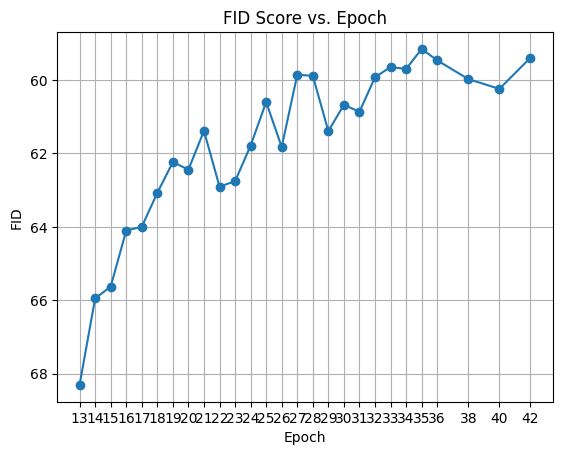

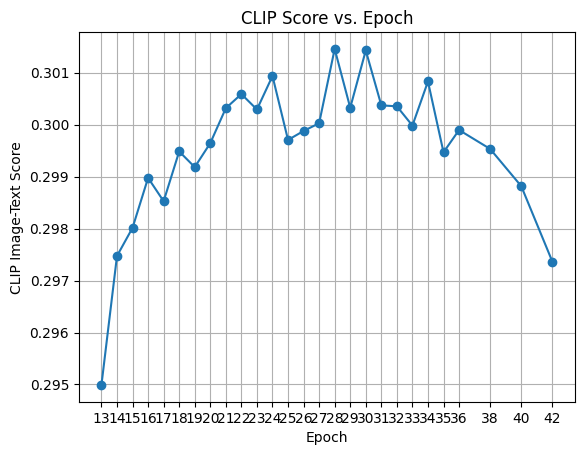

In [ ]:
# 評分資料夾路徑
eval_dir = "/content/generated_eval4"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

### step=10, guidance=2

In [ ]:
# 要測試的 epoch 清單
target_epochs = [10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42,44,45,48,51,54,57,60]

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval1", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/drive/MyDrive/generated_test11_{epoch}_10_2_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=10,
        guidance_scale=2,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval1/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 10: Generating images...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch10.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:07<00:00,  3.74s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:06<00:00,  4.98it/s]


CLIP Image-Text Score: 0.281452
[INFO] Found 1063 images in the zip file.


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 184MB/s] 


[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 80.6006.
✅ Epoch 10 scores:
  FID: 80.6006
  CLIP Image-Text Score: 0.2815

🎯 Epoch 11: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch11.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:02<00:00,  3.60s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


CLIP Image-Text Score: 0.286693
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 74.6403.
✅ Epoch 11 scores:
  FID: 74.6403
  CLIP Image-Text Score: 0.2867

🎯 Epoch 12: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch12.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:03<00:00,  3.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:07<00:00,  4.84it/s]


CLIP Image-Text Score: 0.288441
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 75.3209.
✅ Epoch 12 scores:
  FID: 75.3209
  CLIP Image-Text Score: 0.2884

🎯 Epoch 13: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch13.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:02<00:00,  3.61s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:07<00:00,  4.40it/s]


CLIP Image-Text Score: 0.288932
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 71.2050.
✅ Epoch 13 scores:
  FID: 71.2050
  CLIP Image-Text Score: 0.2889

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:02<00:00,  3.60s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:06<00:00,  4.99it/s]


CLIP Image-Text Score: 0.292155
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 70.1896.
✅ Epoch 14 scores:
  FID: 70.1896
  CLIP Image-Text Score: 0.2922

🎯 Epoch 15: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch15.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:03<00:00,  3.62s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:07<00:00,  4.55it/s]


CLIP Image-Text Score: 0.294740
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 68.4553.
✅ Epoch 15 scores:
  FID: 68.4553
  CLIP Image-Text Score: 0.2947

🎯 Epoch 16: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch16.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:02<00:00,  3.61s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:06<00:00,  4.87it/s]


CLIP Image-Text Score: 0.294989
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 67.0253.
✅ Epoch 16 scores:
  FID: 67.0253
  CLIP Image-Text Score: 0.2950

🎯 Epoch 17: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch17.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [02:01<00:00,  3.57s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


CLIP Image-Text Score: 0.295923
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.4684.
✅ Epoch 17 scores:
  FID: 65.4684
  CLIP Image-Text Score: 0.2959

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating:   6%|▌         | 2/34 [00:08<02:18,  4.32s/it]


KeyboardInterrupt: 

In [ ]:
# 要測試的 epoch 清單
target_epochs = [18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42,44,45,48,51,54,57,60]

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test11_{epoch}_10_2_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=10,
        guidance_scale=2,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval1/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:57<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.83it/s]


CLIP Image-Text Score: 0.296937
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.1790.
✅ Epoch 18 scores:
  FID: 66.1790
  CLIP Image-Text Score: 0.2969

🎯 Epoch 19: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch19.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:57<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.93it/s]


CLIP Image-Text Score: 0.296515
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.5799.
✅ Epoch 19 scores:
  FID: 64.5799
  CLIP Image-Text Score: 0.2965

🎯 Epoch 20: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch20.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.88it/s]


CLIP Image-Text Score: 0.297428
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.3892.
✅ Epoch 20 scores:
  FID: 65.3892
  CLIP Image-Text Score: 0.2974

🎯 Epoch 21: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch21.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.75it/s]


CLIP Image-Text Score: 0.296554
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.9630.
✅ Epoch 21 scores:
  FID: 64.9630
  CLIP Image-Text Score: 0.2966

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:57<00:00,  3.45s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.51it/s]


CLIP Image-Text Score: 0.297176
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.6065.
✅ Epoch 22 scores:
  FID: 65.6065
  CLIP Image-Text Score: 0.2972

🎯 Epoch 23: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch23.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.97it/s]


CLIP Image-Text Score: 0.296629
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.3640.
✅ Epoch 23 scores:
  FID: 64.3640
  CLIP Image-Text Score: 0.2966

🎯 Epoch 24: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch24.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.19it/s]


CLIP Image-Text Score: 0.298166
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.3622.
✅ Epoch 24 scores:
  FID: 64.3622
  CLIP Image-Text Score: 0.2982

🎯 Epoch 25: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch25.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.31it/s]


CLIP Image-Text Score: 0.297287
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.4355.
✅ Epoch 25 scores:
  FID: 63.4355
  CLIP Image-Text Score: 0.2973

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.43it/s]


CLIP Image-Text Score: 0.296513
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.2562.
✅ Epoch 26 scores:
  FID: 64.2562
  CLIP Image-Text Score: 0.2965

🎯 Epoch 27: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch27.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.46it/s]


CLIP Image-Text Score: 0.296901
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.7908.
✅ Epoch 27 scores:
  FID: 63.7908
  CLIP Image-Text Score: 0.2969

🎯 Epoch 28: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch28.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.32it/s]


CLIP Image-Text Score: 0.296894
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.9797.
✅ Epoch 28 scores:
  FID: 63.9797
  CLIP Image-Text Score: 0.2969

🎯 Epoch 29: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch29.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.91it/s]


CLIP Image-Text Score: 0.297214
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.9325.
✅ Epoch 29 scores:
  FID: 63.9325
  CLIP Image-Text Score: 0.2972

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.11it/s]


CLIP Image-Text Score: 0.296743
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.2378.
✅ Epoch 30 scores:
  FID: 64.2378
  CLIP Image-Text Score: 0.2967

🎯 Epoch 31: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch31.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.82it/s]


CLIP Image-Text Score: 0.297503
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.6412.
✅ Epoch 31 scores:
  FID: 63.6412
  CLIP Image-Text Score: 0.2975

🎯 Epoch 32: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch32.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


CLIP Image-Text Score: 0.296315
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.4058.
✅ Epoch 32 scores:
  FID: 64.4058
  CLIP Image-Text Score: 0.2963

🎯 Epoch 33: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch33.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.24it/s]


CLIP Image-Text Score: 0.296250
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.0102.
✅ Epoch 33 scores:
  FID: 64.0102
  CLIP Image-Text Score: 0.2963

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.52it/s]


CLIP Image-Text Score: 0.295195
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.5579.
✅ Epoch 34 scores:
  FID: 64.5579
  CLIP Image-Text Score: 0.2952

🎯 Epoch 35: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch35.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.87it/s]


CLIP Image-Text Score: 0.296279
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.1682.
✅ Epoch 35 scores:
  FID: 63.1682
  CLIP Image-Text Score: 0.2963

🎯 Epoch 36: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch36.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.92it/s]


CLIP Image-Text Score: 0.295662
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.7153.
✅ Epoch 36 scores:
  FID: 63.7153
  CLIP Image-Text Score: 0.2957

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.14it/s]


CLIP Image-Text Score: 0.295577
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.1416.
✅ Epoch 38 scores:
  FID: 64.1416
  CLIP Image-Text Score: 0.2956

🎯 Epoch 40: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch40.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.13it/s]


CLIP Image-Text Score: 0.295026
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.5231.
✅ Epoch 40 scores:
  FID: 64.5231
  CLIP Image-Text Score: 0.2950

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.26it/s]


CLIP Image-Text Score: 0.294582
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.6524.
✅ Epoch 42 scores:
  FID: 64.6524
  CLIP Image-Text Score: 0.2946

🎯 Epoch 44: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch44.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.17it/s]


CLIP Image-Text Score: 0.293201
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.9728.
✅ Epoch 44 scores:
  FID: 65.9728
  CLIP Image-Text Score: 0.2932

🎯 Epoch 45: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch45.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.34it/s]


CLIP Image-Text Score: 0.292750
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.1887.
✅ Epoch 45 scores:
  FID: 65.1887
  CLIP Image-Text Score: 0.2928

🎯 Epoch 48: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch48.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.78it/s]


CLIP Image-Text Score: 0.293448
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.5829.
✅ Epoch 48 scores:
  FID: 66.5829
  CLIP Image-Text Score: 0.2934

🎯 Epoch 51: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch51.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.43it/s]


CLIP Image-Text Score: 0.292996
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.0174.
✅ Epoch 51 scores:
  FID: 66.0174
  CLIP Image-Text Score: 0.2930

🎯 Epoch 54: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch54.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.80it/s]


CLIP Image-Text Score: 0.290940
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.8105.
✅ Epoch 54 scores:
  FID: 66.8105
  CLIP Image-Text Score: 0.2909

🎯 Epoch 57: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch57.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.41it/s]


CLIP Image-Text Score: 0.291621
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.6930.
✅ Epoch 57 scores:
  FID: 66.6930
  CLIP Image-Text Score: 0.2916

🎯 Epoch 60: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch60.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.22it/s]


CLIP Image-Text Score: 0.290523
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 67.4679.
✅ Epoch 60 scores:
  FID: 67.4679
  CLIP Image-Text Score: 0.2905

📊 Summary:
Epoch 18 | FID: 66.1790 | CLIP: 0.2969
Epoch 19 | FID: 64.5799 | CLIP: 0.2965
Epoch 20 | FID: 65.3892 | CLIP: 0.2974
Epoch 21 | FID: 64.9630 | CLIP: 0.2966
Epoch 22 | FID: 65.6065 | CLIP: 0.2972
Epoch 23 | FID: 64.3640 | CLIP: 0.2966
Epoch 24 | FID: 64.3622 | CLIP: 0.2982
Epoch 25 | FID: 63.4355 | CLIP: 0.2973
Epoch 26 | FID: 64.2562 | CLIP: 0.2965
Epoch 27 | FID: 63.7908 | CLIP: 0.2969
Epoch 28 | FID: 63.9797 | CLIP: 0.2969
Epoch 29 | FID: 63.9325 | CLIP: 0.2972
Epoch 30 | FID: 64.2378 | CLIP: 0.2967
Epoch 31 | FID: 63.6412 | CLIP: 0.2975
Epoch 32 | FID: 64.4058 | CLIP: 0.2963
Epoch 33 | FID: 64.0102 | CLIP: 0.2963
Epoch 34 | FID: 64.5579 | CLIP: 0.2952
Epoch 35 | FID: 63.1682 | CLIP: 0.2963
Epoch 36 | FID: 63.7153 | CLIP: 0.2957
Epoch 38 | FID: 64.1416 | CLIP: 0.2956
Epoch 40 | FID: 64.5231 | CLIP: 0.2950
Epoch 42 | FID: 64.6524 | CLIP: 0.2946
Epoch

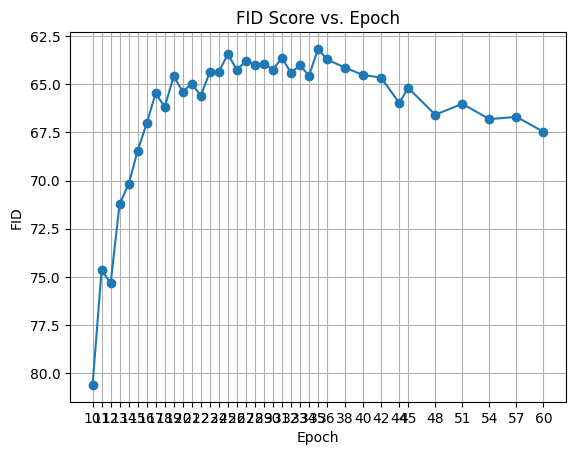

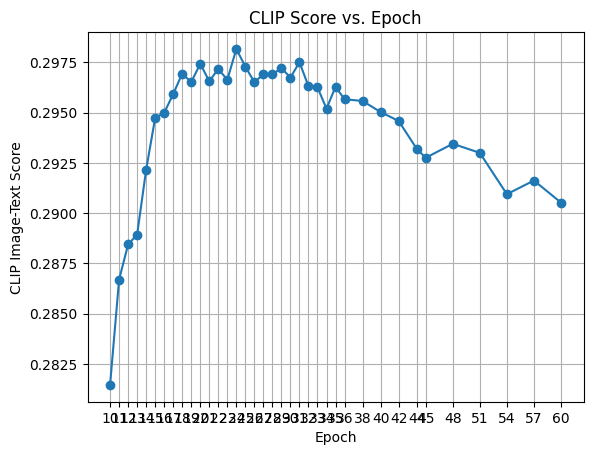

In [ ]:
# 評分資料夾路徑
eval_dir = "/content/generated_eval1"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

### step=10, guidance=3

In [ ]:
# 要測試的 epoch 清單
target_epochs = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42]

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval2", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test11_{epoch}_10_3_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=10,
        guidance_scale=3,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval2/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 13: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch13.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:57<00:00,  3.45s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.10it/s]


CLIP Image-Text Score: 0.292454
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 70.1248.
✅ Epoch 13 scores:
  FID: 70.1248
  CLIP Image-Text Score: 0.2925

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.44s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.14it/s]


CLIP Image-Text Score: 0.295453
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 67.8451.
✅ Epoch 14 scores:
  FID: 67.8451
  CLIP Image-Text Score: 0.2955

🎯 Epoch 15: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch15.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


CLIP Image-Text Score: 0.296855
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.4611.
✅ Epoch 15 scores:
  FID: 66.4611
  CLIP Image-Text Score: 0.2969

🎯 Epoch 16: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch16.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.07it/s]


CLIP Image-Text Score: 0.297044
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.8658.
✅ Epoch 16 scores:
  FID: 66.8658
  CLIP Image-Text Score: 0.2970

🎯 Epoch 17: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch17.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.18it/s]


CLIP Image-Text Score: 0.298122
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.0278.
✅ Epoch 17 scores:
  FID: 64.0278
  CLIP Image-Text Score: 0.2981

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.90it/s]


CLIP Image-Text Score: 0.298840
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.9771.
✅ Epoch 18 scores:
  FID: 63.9771
  CLIP Image-Text Score: 0.2988

🎯 Epoch 19: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch19.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.76it/s]


CLIP Image-Text Score: 0.299505
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.3648.
✅ Epoch 19 scores:
  FID: 63.3648
  CLIP Image-Text Score: 0.2995

🎯 Epoch 20: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch20.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.55it/s]


CLIP Image-Text Score: 0.299409
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.9959.
✅ Epoch 20 scores:
  FID: 62.9959
  CLIP Image-Text Score: 0.2994

🎯 Epoch 21: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch21.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.25it/s]


CLIP Image-Text Score: 0.299132
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.8496.
✅ Epoch 21 scores:
  FID: 62.8496
  CLIP Image-Text Score: 0.2991

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.35it/s]


CLIP Image-Text Score: 0.298612
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.4465.
✅ Epoch 22 scores:
  FID: 63.4465
  CLIP Image-Text Score: 0.2986

🎯 Epoch 23: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch23.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.83it/s]


CLIP Image-Text Score: 0.298797
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.2995.
✅ Epoch 23 scores:
  FID: 62.2995
  CLIP Image-Text Score: 0.2988

🎯 Epoch 24: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch24.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.00it/s]


CLIP Image-Text Score: 0.299995
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.3627.
✅ Epoch 24 scores:
  FID: 63.3627
  CLIP Image-Text Score: 0.3000

🎯 Epoch 25: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch25.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


CLIP Image-Text Score: 0.299843
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.8520.
✅ Epoch 25 scores:
  FID: 62.8520
  CLIP Image-Text Score: 0.2998

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.17it/s]


CLIP Image-Text Score: 0.300178
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.2505.
✅ Epoch 26 scores:
  FID: 63.2505
  CLIP Image-Text Score: 0.3002

🎯 Epoch 27: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch27.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.21it/s]


CLIP Image-Text Score: 0.298760
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.0587.
✅ Epoch 27 scores:
  FID: 61.0587
  CLIP Image-Text Score: 0.2988

🎯 Epoch 28: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch28.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.29it/s]


CLIP Image-Text Score: 0.298914
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.1457.
✅ Epoch 28 scores:
  FID: 61.1457
  CLIP Image-Text Score: 0.2989

🎯 Epoch 29: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch29.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.08it/s]


CLIP Image-Text Score: 0.299107
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.5521.
✅ Epoch 29 scores:
  FID: 61.5521
  CLIP Image-Text Score: 0.2991

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.23it/s]


CLIP Image-Text Score: 0.298909
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.1153.
✅ Epoch 30 scores:
  FID: 62.1153
  CLIP Image-Text Score: 0.2989

🎯 Epoch 31: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch31.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.99it/s]


CLIP Image-Text Score: 0.300043
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.0454.
✅ Epoch 31 scores:
  FID: 61.0454
  CLIP Image-Text Score: 0.3000

🎯 Epoch 32: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch32.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.43s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.83it/s]


CLIP Image-Text Score: 0.300114
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.7837.
✅ Epoch 32 scores:
  FID: 60.7837
  CLIP Image-Text Score: 0.3001

🎯 Epoch 33: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch33.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.18it/s]


CLIP Image-Text Score: 0.299411
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.8989.
✅ Epoch 33 scores:
  FID: 59.8989
  CLIP Image-Text Score: 0.2994

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.20it/s]


CLIP Image-Text Score: 0.299470
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.5715.
✅ Epoch 34 scores:
  FID: 60.5715
  CLIP Image-Text Score: 0.2995

🎯 Epoch 35: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch35.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.09it/s]


CLIP Image-Text Score: 0.298715
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.9921.
✅ Epoch 35 scores:
  FID: 60.9921
  CLIP Image-Text Score: 0.2987

🎯 Epoch 36: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch36.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.32it/s]


CLIP Image-Text Score: 0.298886
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.4174.
✅ Epoch 36 scores:
  FID: 60.4174
  CLIP Image-Text Score: 0.2989

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.29it/s]


CLIP Image-Text Score: 0.299456
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.1642.
✅ Epoch 38 scores:
  FID: 61.1642
  CLIP Image-Text Score: 0.2995

🎯 Epoch 40: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch40.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.66it/s]


CLIP Image-Text Score: 0.297266
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.7668.
✅ Epoch 40 scores:
  FID: 60.7668
  CLIP Image-Text Score: 0.2973

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.35it/s]


CLIP Image-Text Score: 0.296329
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.2857.
✅ Epoch 42 scores:
  FID: 61.2857
  CLIP Image-Text Score: 0.2963

📊 Summary:
Epoch 13 | FID: 70.1248 | CLIP: 0.2925
Epoch 14 | FID: 67.8451 | CLIP: 0.2955
Epoch 15 | FID: 66.4611 | CLIP: 0.2969
Epoch 16 | FID: 66.8658 | CLIP: 0.2970
Epoch 17 | FID: 64.0278 | CLIP: 0.2981
Epoch 18 | FID: 63.9771 | CLIP: 0.2988
Epoch 19 | FID: 63.3648 | CLIP: 0.2995
Epoch 20 | FID: 62.9959 | CLIP: 0.2994
Epoch 21 | FID: 62.8496 | CLIP: 0.2991
Epoch 22 | FID: 63.4465 | CLIP: 0.2986
Epoch 23 | FID: 62.2995 | CLIP: 0.2988
Epoch 24 | FID: 63.3627 | CLIP: 0.3000
Epoch 25 | FID: 62.8520 | CLIP: 0.2998
Epoch 26 | FID: 63.2505 | CLIP: 0.3002
Epoch 27 | FID: 61.0587 | CLIP: 0.2988
Epoch 28 | FID: 61.1457 | CLIP: 0.2989
Epoch 29 | FID: 61.5521 | CLIP: 0.2991
Epoch 30 | FID: 62.1153 | CLIP: 0.2989
Epoch 31 | FID: 61.0454 | CLIP: 0.3000
Epoch 32 | FID: 60.7837 | CLIP: 0.3001
Epoch 33 | FID: 59.8989 | CLIP: 0.2994
Epoch 34 | FID: 60.5715 | CLIP: 0.2995
Epoch

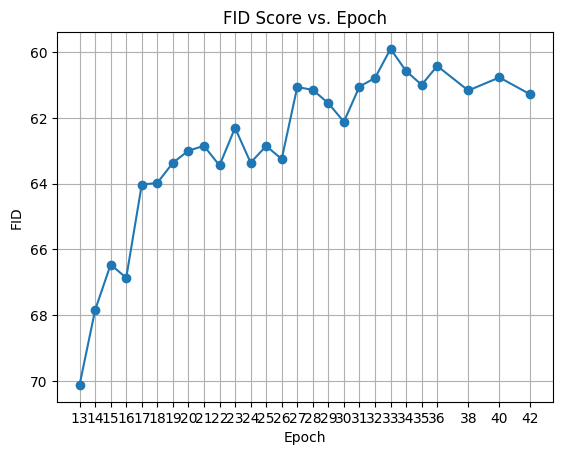

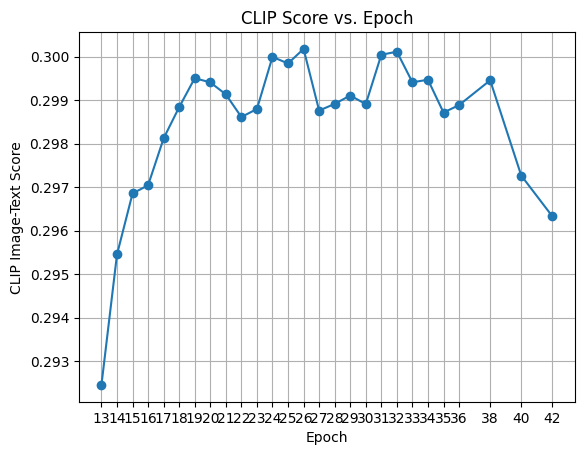

In [ ]:
# 評分資料夾路徑
eval_dir = "/content/generated_eval2"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

### step=10, guidance=4

In [ ]:
# 要測試的 epoch 清單
target_epochs = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42]

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval3", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test11_{epoch}_10_4_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=10,
        guidance_scale=4,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval2/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 13: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch13.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.42s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.69it/s]


CLIP Image-Text Score: 0.294223
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 70.0928.
✅ Epoch 13 scores:
  FID: 70.0928
  CLIP Image-Text Score: 0.2942

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:56<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


CLIP Image-Text Score: 0.296479
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 68.9764.
✅ Epoch 14 scores:
  FID: 68.9764
  CLIP Image-Text Score: 0.2965

🎯 Epoch 15: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch15.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.27it/s]


CLIP Image-Text Score: 0.296498
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 68.5255.
✅ Epoch 15 scores:
  FID: 68.5255
  CLIP Image-Text Score: 0.2965

🎯 Epoch 16: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch16.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.52it/s]


CLIP Image-Text Score: 0.296929
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.6108.
✅ Epoch 16 scores:
  FID: 66.6108
  CLIP Image-Text Score: 0.2969

🎯 Epoch 17: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch17.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.68it/s]


CLIP Image-Text Score: 0.297091
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.9598.
✅ Epoch 17 scores:
  FID: 64.9598
  CLIP Image-Text Score: 0.2971

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.36it/s]


CLIP Image-Text Score: 0.298420
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 65.0805.
✅ Epoch 18 scores:
  FID: 65.0805
  CLIP Image-Text Score: 0.2984

🎯 Epoch 19: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch19.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.98it/s]


CLIP Image-Text Score: 0.299213
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.7601.
✅ Epoch 19 scores:
  FID: 63.7601
  CLIP Image-Text Score: 0.2992

🎯 Epoch 20: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch20.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.46it/s]


CLIP Image-Text Score: 0.298358
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.1158.
✅ Epoch 20 scores:
  FID: 64.1158
  CLIP Image-Text Score: 0.2984

🎯 Epoch 21: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch21.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.25it/s]


CLIP Image-Text Score: 0.299019
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.0950.
✅ Epoch 21 scores:
  FID: 63.0950
  CLIP Image-Text Score: 0.2990

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.31it/s]


CLIP Image-Text Score: 0.300815
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.4714.
✅ Epoch 22 scores:
  FID: 63.4714
  CLIP Image-Text Score: 0.3008

🎯 Epoch 23: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch23.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.24it/s]


CLIP Image-Text Score: 0.299581
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.0954.
✅ Epoch 23 scores:
  FID: 63.0954
  CLIP Image-Text Score: 0.2996

🎯 Epoch 24: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch24.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.70it/s]


CLIP Image-Text Score: 0.300252
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.4925.
✅ Epoch 24 scores:
  FID: 63.4925
  CLIP Image-Text Score: 0.3003

🎯 Epoch 25: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch25.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.22it/s]


CLIP Image-Text Score: 0.300890
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.0672.
✅ Epoch 25 scores:
  FID: 63.0672
  CLIP Image-Text Score: 0.3009

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.54it/s]


CLIP Image-Text Score: 0.299858
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.2836.
✅ Epoch 26 scores:
  FID: 63.2836
  CLIP Image-Text Score: 0.2999

🎯 Epoch 27: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch27.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.36it/s]


CLIP Image-Text Score: 0.299414
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.3828.
✅ Epoch 27 scores:
  FID: 61.3828
  CLIP Image-Text Score: 0.2994

🎯 Epoch 28: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch28.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.07it/s]


CLIP Image-Text Score: 0.300282
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.9598.
✅ Epoch 28 scores:
  FID: 61.9598
  CLIP Image-Text Score: 0.3003

🎯 Epoch 29: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch29.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.93it/s]


CLIP Image-Text Score: 0.300840
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.5367.
✅ Epoch 29 scores:
  FID: 61.5367
  CLIP Image-Text Score: 0.3008

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.90it/s]


CLIP Image-Text Score: 0.300817
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.3287.
✅ Epoch 30 scores:
  FID: 62.3287
  CLIP Image-Text Score: 0.3008

🎯 Epoch 31: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch31.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.90it/s]


CLIP Image-Text Score: 0.300463
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.3027.
✅ Epoch 31 scores:
  FID: 61.3027
  CLIP Image-Text Score: 0.3005

🎯 Epoch 32: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch32.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.17it/s]


CLIP Image-Text Score: 0.299690
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.4325.
✅ Epoch 32 scores:
  FID: 61.4325
  CLIP Image-Text Score: 0.2997

🎯 Epoch 33: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch33.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.69it/s]


CLIP Image-Text Score: 0.299698
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.8929.
✅ Epoch 33 scores:
  FID: 60.8929
  CLIP Image-Text Score: 0.2997

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.39s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.30it/s]


CLIP Image-Text Score: 0.299274
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.6082.
✅ Epoch 34 scores:
  FID: 60.6082
  CLIP Image-Text Score: 0.2993

🎯 Epoch 35: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch35.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.36it/s]


CLIP Image-Text Score: 0.300813
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.8461.
✅ Epoch 35 scores:
  FID: 60.8461
  CLIP Image-Text Score: 0.3008

🎯 Epoch 36: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch36.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.46it/s]


CLIP Image-Text Score: 0.299950
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.9650.
✅ Epoch 36 scores:
  FID: 60.9650
  CLIP Image-Text Score: 0.2999

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.41s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.06it/s]


CLIP Image-Text Score: 0.300232
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.1944.
✅ Epoch 38 scores:
  FID: 61.1944
  CLIP Image-Text Score: 0.3002

🎯 Epoch 40: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch40.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.16it/s]


CLIP Image-Text Score: 0.298465
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.8588.
✅ Epoch 40 scores:
  FID: 60.8588
  CLIP Image-Text Score: 0.2985

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [01:55<00:00,  3.40s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.72it/s]


CLIP Image-Text Score: 0.297340
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.9871.
✅ Epoch 42 scores:
  FID: 61.9871
  CLIP Image-Text Score: 0.2973

📊 Summary:
Epoch 13 | FID: 70.0928 | CLIP: 0.2942
Epoch 14 | FID: 68.9764 | CLIP: 0.2965
Epoch 15 | FID: 68.5255 | CLIP: 0.2965
Epoch 16 | FID: 66.6108 | CLIP: 0.2969
Epoch 17 | FID: 64.9598 | CLIP: 0.2971
Epoch 18 | FID: 65.0805 | CLIP: 0.2984
Epoch 19 | FID: 63.7601 | CLIP: 0.2992
Epoch 20 | FID: 64.1158 | CLIP: 0.2984
Epoch 21 | FID: 63.0950 | CLIP: 0.2990
Epoch 22 | FID: 63.4714 | CLIP: 0.3008
Epoch 23 | FID: 63.0954 | CLIP: 0.2996
Epoch 24 | FID: 63.4925 | CLIP: 0.3003
Epoch 25 | FID: 63.0672 | CLIP: 0.3009
Epoch 26 | FID: 63.2836 | CLIP: 0.2999
Epoch 27 | FID: 61.3828 | CLIP: 0.2994
Epoch 28 | FID: 61.9598 | CLIP: 0.3003
Epoch 29 | FID: 61.5367 | CLIP: 0.3008
Epoch 30 | FID: 62.3287 | CLIP: 0.3008
Epoch 31 | FID: 61.3027 | CLIP: 0.3005
Epoch 32 | FID: 61.4325 | CLIP: 0.2997
Epoch 33 | FID: 60.8929 | CLIP: 0.2997
Epoch 34 | FID: 60.6082 | CLIP: 0.2993
Epoch

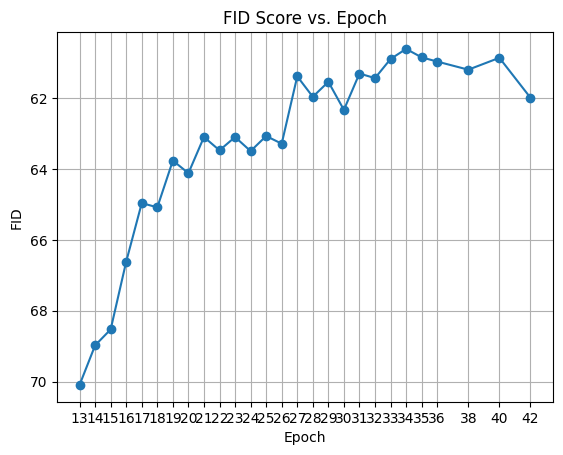

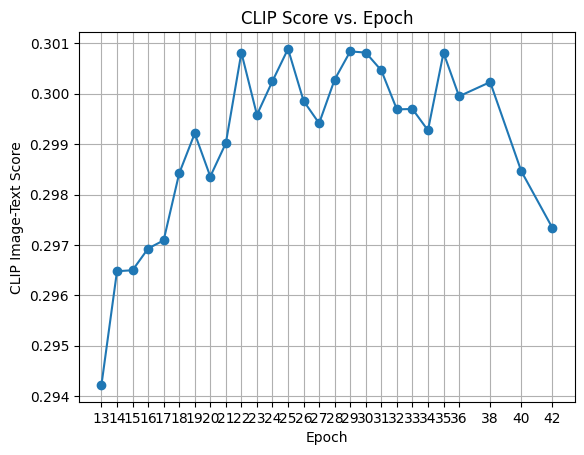

In [ ]:
# 評分資料夾路徑
eval_dir = "/content/generated_eval2"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

### step=20, guidance=3

In [ ]:
# 要測試的 epoch 清單
target_epochs = [13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,38,40,42]
# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval5", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test11_{epoch}_20_3_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=20,
        guidance_scale=3,
        batch_size=32
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval5/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 13: Generating images...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch13.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:20<00:00,  5.91s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.99it/s]


CLIP Image-Text Score: 0.294908
[INFO] Found 1063 images in the zip file.


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 183MB/s] 


[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 68.6697.
✅ Epoch 13 scores:
  FID: 68.6697
  CLIP Image-Text Score: 0.2949

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.95it/s]


CLIP Image-Text Score: 0.296486
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.4579.
✅ Epoch 14 scores:
  FID: 66.4579
  CLIP Image-Text Score: 0.2965

🎯 Epoch 15: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch15.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.89it/s]


CLIP Image-Text Score: 0.296908
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 66.0960.
✅ Epoch 15 scores:
  FID: 66.0960
  CLIP Image-Text Score: 0.2969

🎯 Epoch 16: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch16.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.95it/s]


CLIP Image-Text Score: 0.298338
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 64.4597.
✅ Epoch 16 scores:
  FID: 64.4597
  CLIP Image-Text Score: 0.2983

🎯 Epoch 17: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch17.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.14it/s]


CLIP Image-Text Score: 0.298256
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.4555.
✅ Epoch 17 scores:
  FID: 63.4555
  CLIP Image-Text Score: 0.2983

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.15it/s]


CLIP Image-Text Score: 0.299338
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.7977.
✅ Epoch 18 scores:
  FID: 62.7977
  CLIP Image-Text Score: 0.2993

🎯 Epoch 19: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch19.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.37it/s]


CLIP Image-Text Score: 0.299972
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.6113.
✅ Epoch 19 scores:
  FID: 63.6113
  CLIP Image-Text Score: 0.3000

🎯 Epoch 20: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch20.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.91it/s]


CLIP Image-Text Score: 0.300132
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 63.0056.
✅ Epoch 20 scores:
  FID: 63.0056
  CLIP Image-Text Score: 0.3001

🎯 Epoch 21: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch21.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.33it/s]


CLIP Image-Text Score: 0.300848
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.9337.
✅ Epoch 21 scores:
  FID: 61.9337
  CLIP Image-Text Score: 0.3008

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.16it/s]


CLIP Image-Text Score: 0.299405
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.5564.
✅ Epoch 22 scores:
  FID: 62.5564
  CLIP Image-Text Score: 0.2994

🎯 Epoch 23: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch23.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.56it/s]


CLIP Image-Text Score: 0.299557
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.2401.
✅ Epoch 23 scores:
  FID: 62.2401
  CLIP Image-Text Score: 0.2996

🎯 Epoch 24: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch24.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.10it/s]


CLIP Image-Text Score: 0.300512
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.7336.
✅ Epoch 24 scores:
  FID: 62.7336
  CLIP Image-Text Score: 0.3005

🎯 Epoch 25: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch25.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.05it/s]


CLIP Image-Text Score: 0.300973
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 61.9212.
✅ Epoch 25 scores:
  FID: 61.9212
  CLIP Image-Text Score: 0.3010

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.29it/s]


CLIP Image-Text Score: 0.300863
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 62.0865.
✅ Epoch 26 scores:
  FID: 62.0865
  CLIP Image-Text Score: 0.3009

🎯 Epoch 27: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch27.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.12it/s]


CLIP Image-Text Score: 0.300560
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.8727.
✅ Epoch 27 scores:
  FID: 60.8727
  CLIP Image-Text Score: 0.3006

🎯 Epoch 28: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch28.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.74it/s]


CLIP Image-Text Score: 0.300372
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.4241.
✅ Epoch 28 scores:
  FID: 60.4241
  CLIP Image-Text Score: 0.3004

🎯 Epoch 29: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch29.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.03it/s]


CLIP Image-Text Score: 0.300731
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.9483.
✅ Epoch 29 scores:
  FID: 60.9483
  CLIP Image-Text Score: 0.3007

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.14it/s]


CLIP Image-Text Score: 0.300880
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.7125.
✅ Epoch 30 scores:
  FID: 59.7125
  CLIP Image-Text Score: 0.3009

🎯 Epoch 31: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch31.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.01it/s]


CLIP Image-Text Score: 0.301304
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.7028.
✅ Epoch 31 scores:
  FID: 60.7028
  CLIP Image-Text Score: 0.3013

🎯 Epoch 32: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch32.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.39it/s]


CLIP Image-Text Score: 0.300244
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.2968.
✅ Epoch 32 scores:
  FID: 60.2968
  CLIP Image-Text Score: 0.3002

🎯 Epoch 33: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch33.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.85it/s]


CLIP Image-Text Score: 0.300314
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.6059.
✅ Epoch 33 scores:
  FID: 59.6059
  CLIP Image-Text Score: 0.3003

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 18.09it/s]


CLIP Image-Text Score: 0.299622
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.7088.
✅ Epoch 34 scores:
  FID: 59.7088
  CLIP Image-Text Score: 0.2996

🎯 Epoch 35: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch35.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.27it/s]


CLIP Image-Text Score: 0.298872
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.3112.
✅ Epoch 35 scores:
  FID: 59.3112
  CLIP Image-Text Score: 0.2989

🎯 Epoch 36: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch36.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.82it/s]


CLIP Image-Text Score: 0.299800
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.0075.
✅ Epoch 36 scores:
  FID: 60.0075
  CLIP Image-Text Score: 0.2998

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.52it/s]


CLIP Image-Text Score: 0.299133
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.7688.
✅ Epoch 38 scores:
  FID: 59.7688
  CLIP Image-Text Score: 0.2991

🎯 Epoch 40: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch40.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:18<00:00,  5.85s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.95it/s]


CLIP Image-Text Score: 0.299596
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 59.7540.
✅ Epoch 40 scores:
  FID: 59.7540
  CLIP Image-Text Score: 0.2996

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=32


Batch generating: 100%|██████████| 34/34 [03:19<00:00,  5.86s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.63it/s]


CLIP Image-Text Score: 0.298229
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 60.0472.
✅ Epoch 42 scores:
  FID: 60.0472
  CLIP Image-Text Score: 0.2982

📊 Summary:
Epoch 13 | FID: 68.6697 | CLIP: 0.2949
Epoch 14 | FID: 66.4579 | CLIP: 0.2965
Epoch 15 | FID: 66.0960 | CLIP: 0.2969
Epoch 16 | FID: 64.4597 | CLIP: 0.2983
Epoch 17 | FID: 63.4555 | CLIP: 0.2983
Epoch 18 | FID: 62.7977 | CLIP: 0.2993
Epoch 19 | FID: 63.6113 | CLIP: 0.3000
Epoch 20 | FID: 63.0056 | CLIP: 0.3001
Epoch 21 | FID: 61.9337 | CLIP: 0.3008
Epoch 22 | FID: 62.5564 | CLIP: 0.2994
Epoch 23 | FID: 62.2401 | CLIP: 0.2996
Epoch 24 | FID: 62.7336 | CLIP: 0.3005
Epoch 25 | FID: 61.9212 | CLIP: 0.3010
Epoch 26 | FID: 62.0865 | CLIP: 0.3009
Epoch 27 | FID: 60.8727 | CLIP: 0.3006
Epoch 28 | FID: 60.4241 | CLIP: 0.3004
Epoch 29 | FID: 60.9483 | CLIP: 0.3007
Epoch 30 | FID: 59.7125 | CLIP: 0.3009
Epoch 31 | FID: 60.7028 | CLIP: 0.3013
Epoch 32 | FID: 60.2968 | CLIP: 0.3002
Epoch 33 | FID: 59.6059 | CLIP: 0.3003
Epoch 34 | FID: 59.7088 | CLIP: 0.2996
Epoch

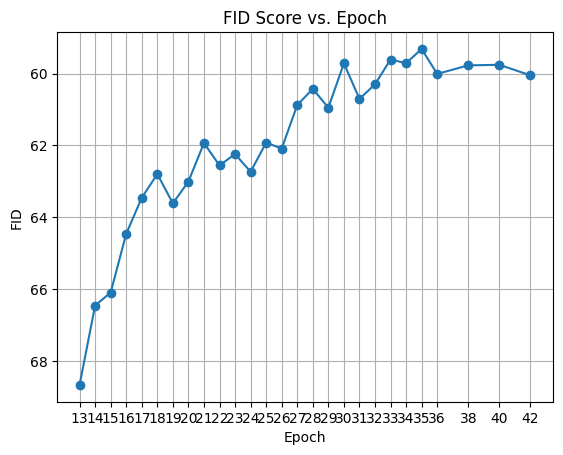

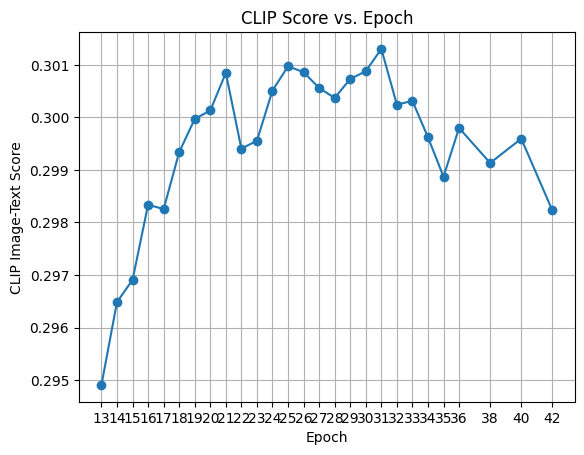

In [ ]:
# 評分資料夾路徑
eval_dir = "/content/generated_eval5"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

## DDIM

In [ ]:
@torch.no_grad()
def generate_batch(prompts, unet, vae, tokenizer, text_encoder, device, steps=50, guidance_scale=7.5):
    unet.eval()
    scheduler = DDIMScheduler()
    scheduler.set_timesteps(steps)
    scheduler.eta = 0.0

    batch_size = len(prompts)
    cond_ids = tokenizer(prompts, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.to(device)
    uncond_ids = tokenizer([""] * batch_size, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.to(device)

    cond_emb = text_encoder(cond_ids)[0]
    uncond_emb = text_encoder(uncond_ids)[0]
    encoder_input = torch.cat([uncond_emb, cond_emb], dim=0)  # (2B, 77, D)

    latents = torch.randn((batch_size, 4, 32, 32)).to(device)

    for t in scheduler.timesteps:
        latent_input = latents.repeat(2, 1, 1, 1)
        noise_pred = unet(latent_input, t.to(device), encoder_hidden_states=encoder_input).sample
        noise_pred_uncond, noise_pred_cond = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    latents = latents / 0.18215
    images = vae.decode(latents, return_dict=False)[0]
    images = (images.clamp(-1, 1) + 1) / 2

    pil_images = [transforms.ToPILImage()(img.cpu()) for img in images]
    return pil_images

def test_inference(ckpt_path, test_json_path, save_folder, device="cuda", steps=50, guidance_scale=7.5, batch_size=4):
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").eval().to(device)
    text_encoder.requires_grad_(False)
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
    vae.requires_grad_(False)

    print(f"🔍 Loading checkpoint: {ckpt_path}")
    # 1. 初始化 unet（使用原始 config）
    # 本地路徑，不需要再用 from_config()，而是直接用 from_pretrained()
    # 1. 建立一樣的 UNet 架構
    unet = UNet2DConditionModel(
    sample_size=32,
    in_channels=4,
    out_channels=4,
    block_out_channels=(192, 384, 768, 768),
    layers_per_block=2,
    down_block_types=(
        "CrossAttnDownBlock2D", "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D", "CrossAttnDownBlock2D"
    ),
    up_block_types=(
        "CrossAttnUpBlock2D", "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"
    ),
    cross_attention_dim=512,
    attention_head_dim=8
    ).to(device)

    # 2. 載入訓練好的權重（推薦用 EMA）
    ckpt = torch.load(ckpt_path, map_location=device)
    if "ema" in ckpt:
        print("✅ Using EMA weights")
        unet.load_state_dict(ckpt["ema"])
    else:
        print("⚠️ Using raw UNet weights")
        unet.load_state_dict(ckpt["unet"])

    os.makedirs(save_folder, exist_ok=True)
    with open(test_json_path, "r") as f:
        test_data = list(json.load(f).items())  # 轉成 list 才能 batch

    print(f"🚀 Start batch inference: {len(test_data)} samples | Batch size={batch_size}")
    for i in tqdm(range(0, len(test_data), batch_size), desc="Batch generating"):
        batch_items = test_data[i:i+batch_size]
        prompts = [item[1]["text_prompt"] for item in batch_items]
        filenames = [item[1]["image_name"] for item in batch_items]

        images = generate_batch(prompts, unet, vae, tokenizer, text_encoder, device,
                                steps=steps, guidance_scale=guidance_scale)
        for img, fname in zip(images, filenames):
            img.save(os.path.join(save_folder, fname))



### Step=10, guidance=2

In [ ]:
# 要測試的 epoch 清單（每兩個存一個）
target_epochs = list(range(6, 61, 4))

# 固定參數設定
test_json_path = "/content/test.json"
ref_mu_path = "/content/drive/MyDrive/public_data/score/test_mu.npy"
ref_sigma_path = "/content/drive/MyDrive/public_data/score/test_sigma.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

result_list = []
os.makedirs("/content/generated_eval1", exist_ok=True)
for epoch in target_epochs:
    ckpt_path = f"/content/drive/MyDrive/DDIM11/ckpt/checkpoint_epoch{epoch}.pt"
    save_folder = f"/content/generated_test6_{epoch}_10_2_2"
    os.makedirs(save_folder, exist_ok=True)

    print(f"\n🎯 Epoch {epoch}: Generating images...")

    # 推論產圖
    test_inference(
        ckpt_path=ckpt_path,
        test_json_path=test_json_path,
        save_folder=save_folder,
        steps=10,
        guidance_scale=2,
        batch_size=16
    )

    # 設定評分參數
    args = SimpleNamespace(
        ref_mu_path=ref_mu_path,
        ref_sigma_path=ref_sigma_path,
        test_json_path=test_json_path,
        fake_img_root=save_folder,
        image_size=256,
        num_images=None,
        scores=["fid", "clip_t"],
        model_name="ViT-B-32-quickgelu",
        pretrained="openai",
        batch_size=32,
        num_workers=2,
        verbose=True,
        output_path=f"/content/generated_eval1/scores_ep{epoch}.json"
    )

    # 執行評分
    output_json = {}
    if 'clip_i' in args.scores or 'clip_t' in args.scores:
        output_json.update(run_clip(args, device))
    if 'fid' in args.scores:
        output_json.update(run_fid(args, device))

    # 印出分數
    print(f"✅ Epoch {epoch} scores:")
    for key in ["FID", "CLIP Image-Text Score"]:
        if key in output_json:
            print(f"  {key}: {output_json[key]:.4f}")

    # 儲存分數
    with open(args.output_path, "w") as f:
        json.dump(output_json, f, indent=2)

    # 收集結果
    result_list.append({
        "epoch": epoch,
        "FID": output_json.get("FID", None),
        "CLIP": output_json.get("CLIP Image-Text Score", None)
    })

# 總結
print("\n📊 Summary:")
for r in result_list:
    print(f"Epoch {r['epoch']:>2} | FID: {r['FID']:.4f} | CLIP: {r['CLIP']:.4f}")


🎯 Epoch 6: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch6.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:51<00:00,  1.66s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 15.45it/s]


CLIP Image-Text Score: 0.253743
[INFO] Found 1063 images in the zip file.


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 168MB/s] 


[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 150.6101.
✅ Epoch 6 scores:
  FID: 150.6101
  CLIP Image-Text Score: 0.2537

🎯 Epoch 10: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch10.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:51<00:00,  1.67s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.28it/s]


CLIP Image-Text Score: 0.269237
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 124.3254.
✅ Epoch 10 scores:
  FID: 124.3254
  CLIP Image-Text Score: 0.2692

🎯 Epoch 14: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch14.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:51<00:00,  1.66s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.11it/s]


CLIP Image-Text Score: 0.272801
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 116.0131.
✅ Epoch 14 scores:
  FID: 116.0131
  CLIP Image-Text Score: 0.2728

🎯 Epoch 18: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch18.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:50<00:00,  1.66s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.66it/s]


CLIP Image-Text Score: 0.273701
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 112.6028.
✅ Epoch 18 scores:
  FID: 112.6028
  CLIP Image-Text Score: 0.2737

🎯 Epoch 22: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch22.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:50<00:00,  1.65s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.23it/s]


CLIP Image-Text Score: 0.273877
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 116.6643.
✅ Epoch 22 scores:
  FID: 116.6643
  CLIP Image-Text Score: 0.2739

🎯 Epoch 26: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch26.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:50<00:00,  1.65s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.43it/s]


CLIP Image-Text Score: 0.271789
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 118.1588.
✅ Epoch 26 scores:
  FID: 118.1588
  CLIP Image-Text Score: 0.2718

🎯 Epoch 30: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch30.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:50<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.63it/s]


CLIP Image-Text Score: 0.268659
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 125.7019.
✅ Epoch 30 scores:
  FID: 125.7019
  CLIP Image-Text Score: 0.2687

🎯 Epoch 34: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch34.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.66it/s]


CLIP Image-Text Score: 0.264361
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 130.9351.
✅ Epoch 34 scores:
  FID: 130.9351
  CLIP Image-Text Score: 0.2644

🎯 Epoch 38: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch38.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.47it/s]


CLIP Image-Text Score: 0.260957
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 136.2790.
✅ Epoch 38 scores:
  FID: 136.2790
  CLIP Image-Text Score: 0.2610

🎯 Epoch 42: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch42.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:01<00:00, 17.02it/s]


CLIP Image-Text Score: 0.257984
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 141.1666.
✅ Epoch 42 scores:
  FID: 141.1666
  CLIP Image-Text Score: 0.2580

🎯 Epoch 46: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch46.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.24it/s]


CLIP Image-Text Score: 0.255257
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 145.5290.
✅ Epoch 46 scores:
  FID: 145.5290
  CLIP Image-Text Score: 0.2553

🎯 Epoch 50: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch50.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.63s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.86it/s]


CLIP Image-Text Score: 0.253520
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 147.9781.
✅ Epoch 50 scores:
  FID: 147.9781
  CLIP Image-Text Score: 0.2535

🎯 Epoch 54: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch54.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 16.39it/s]


CLIP Image-Text Score: 0.251079
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 150.9777.
✅ Epoch 54 scores:
  FID: 150.9777
  CLIP Image-Text Score: 0.2511

🎯 Epoch 58: Generating images...
🔍 Loading checkpoint: /content/drive/MyDrive/DDIM6/ckpt/checkpoint_epoch58.pt
✅ Using EMA weights
🚀 Start batch inference: 1063 samples | Batch size=16


Batch generating: 100%|██████████| 67/67 [01:49<00:00,  1.64s/it]


[INFO] Loading test JSON file: /content/test.json.
[INFO] Found 1063 images in the zip file.
[INFO] Checking if all image paths from the test JSON file are present in the zip file.
[INFO] Loading CLIP model: ViT-B-32-quickgelu with pretrained weights: openai.
[INFO] Calculating CLIP scores for 1063 images...


100%|██████████| 34/34 [00:02<00:00, 15.53it/s]


CLIP Image-Text Score: 0.250670
[INFO] Found 1063 images in the zip file.
[INFO] Generating Inception model features...


[INFO] Calculating FID score...
[INFO] FID score: 152.8288.
✅ Epoch 58 scores:
  FID: 152.8288
  CLIP Image-Text Score: 0.2507

📊 Summary:
Epoch  6 | FID: 150.6101 | CLIP: 0.2537
Epoch 10 | FID: 124.3254 | CLIP: 0.2692
Epoch 14 | FID: 116.0131 | CLIP: 0.2728
Epoch 18 | FID: 112.6028 | CLIP: 0.2737
Epoch 22 | FID: 116.6643 | CLIP: 0.2739
Epoch 26 | FID: 118.1588 | CLIP: 0.2718
Epoch 30 | FID: 125.7019 | CLIP: 0.2687
Epoch 34 | FID: 130.9351 | CLIP: 0.2644
Epoch 38 | FID: 136.2790 | CLIP: 0.2610
Epoch 42 | FID: 141.1666 | CLIP: 0.2580
Epoch 46 | FID: 145.5290 | CLIP: 0.2553
Epoch 50 | FID: 147.9781 | CLIP: 0.2535
Epoch 54 | FID: 150.9777 | CLIP: 0.2511
Epoch 58 | FID: 152.8288 | CLIP: 0.2507


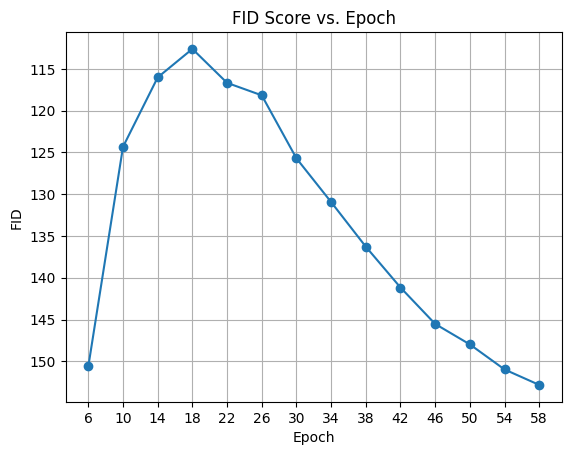

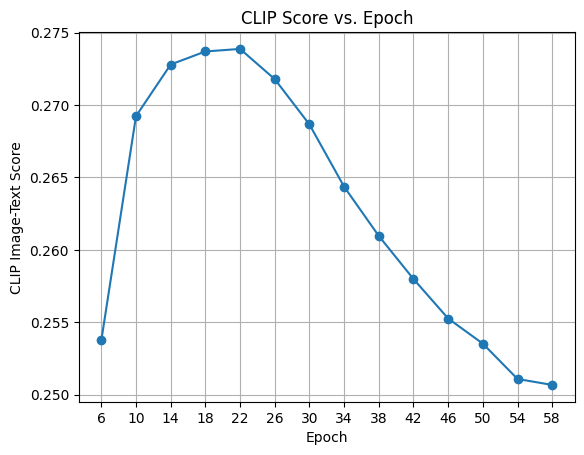

In [ ]:
import os
import re
import json
import matplotlib.pyplot as plt

# 評分資料夾路徑
eval_dir = "/content/generated_eval1"

# 讀取所有 scores_ep*.json
result_list = []
for fname in sorted(os.listdir(eval_dir)):
    match = re.match(r"scores_ep(\d+)\.json", fname)
    if match:
        epoch = int(match.group(1))
        with open(os.path.join(eval_dir, fname), "r") as f:
            data = json.load(f)
            result_list.append({
                "epoch": epoch,
                "FID": data.get("FID", None),
                "CLIP": data.get("CLIP Image-Text Score", None)
            })

# 照 epoch 排序
result_list.sort(key=lambda x: x["epoch"])

# 提取資料
epochs = [r["epoch"] for r in result_list]
fid_scores = [r["FID"] for r in result_list]
clip_scores = [r["CLIP"] for r in result_list]

# 畫 FID vs. Epoch
plt.figure()
plt.plot(epochs, fid_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.title("FID Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.gca().invert_yaxis()  # FID 越低越好
plt.show()

# 畫 CLIP Score vs. Epoch
plt.figure()
plt.plot(epochs, clip_scores, marker='o')
plt.xlabel("Epoch")
plt.ylabel("CLIP Image-Text Score")
plt.title("CLIP Score vs. Epoch")
plt.grid(True)
plt.xticks(epochs)
plt.show()

In [ ]:
import shutil

# 將 generated_images 資料夾壓縮成 zip
shutil.make_archive("generated_test6_20_10_2_2", "zip", "generated_test6_20_10_2_2")

print("✅ 壓縮完成，可下載 generated_images.zip 檔案")
from google.colab import files

files.download("/content/generated_test6_20_10_2_2.zip")
print("✅ 預測完成，generated_images.zip 已儲存並下載。")

✅ 壓縮完成，可下載 generated_images.zip 檔案


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ 預測完成，generated_images.zip 已儲存並下載。
